In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [2]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
output_base_folder = Path("/home/ivan/temp/temp-benchmarking/")


# End to End benchmark
---
Storage performance test on S3 and Scratch with changing the size of the batch, number of workers, number of fetchers, and memory pinning.

**Experiment parameters**

| param | range |
| --- | --- |
| batch size | 16, 32, 64 | 
| num fetch workers |  4, 8, 16, 32 | 
| num workers |  0,  4,  8, 16 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |
| pin memory | True, False | 

---

### TOC:
* [S3 Storage](#s3storage)
* [S3 Async vs Threaded Dataloader](#s3asynciovsthreaded)
* [Scratch Storage](#scratchstorage)
* [Scratch Async vs Threaded Dataloader](#scratchasynciovsthreaded)
* [S3 vs Scratch](#s3vsscratch)

**Parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch size | asyncio | --- |
| | threaded | --- |
| num fetch workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initiall placed into the task (worker) queue. |
| | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |
| num workers | asyncio | Number of workers that download batches in paralell (while batch items are usually fetched sequentially, here, they are fetched asynchronously) |
| | threaded | The same as for asyncio implementation, however, batch items are fetched with parallel threads and yealded. Once a batch is collected, it is yealded(1). |
| pin memory (2) | asyncio | Host (CPU) data allocations are pageable by default. The GPU cannot access data directly from pageable host memory, so when a data transfer from pageable host memory to device memory is invoked, the CUDA driver must first allocate a temporary page-locked, or “pinned”, host array, copy the host data to the pinned array, and then transfer the data from the pinned array to device memory. Pinned memory is used as a staging area for transfers from the device to the host. We can avoid the cost of the transfer between pageable and pinned host arrays by directly allocating our host arrays in pinned memory. |
| | threaded | Same as for asyncio |

(1) batch_pool_size - Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentiall or in parallel). This implementation takes N batches, and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded. Fixed to 10, as previous experiments show it doesn't have much influence. 

(2) https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

**In all plots, lower is better!**

Testing script:

```bash
for pin_memory in 0 1; do
  for fetch_impl in "threaded" "asyncio"; do
    for storage in "s3" "scratch"; do
      for batch_size in 16 32 64; do
        for num_workers in 0 4 8 16; do
          for num_fetch_workers in 4 8 16 32; do
            python3 train/imagenet.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/e2e \
            --dataset "${storage}" \
            --num-fetch-workers "${num_fetch_workers}" \
            --num-workers "${num_workers}" \
            --dataset-limit 1024 \
            --batch-size "${batch_size}" \
            --prefetch-factor 2 \
            --fetch-impl "${fetch_impl}" \
            --pin-memory "${pin_memory}" \
            --accelerator dp
          done
        done
      done
    done
  done
done
```

## S3 Storage <a class="anchor" id="s3storage">

In [3]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool"]

In [4]:
s3_folder_filter = "e2e0810/*benchmark_e2e_s3*"

In [5]:
df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8015/8015 [02:49<00:00, 47.40it/s]


In [6]:
# output_base_folder = Path("/home/ivan/temp/temp-benchmarking/e2e0810")
df_s3_gpu_util = extract_gpu_utilization(output_base_folder, folder_filter=s3_folder_filter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 83.87it/s]


In [7]:
df_dataloader_s3_async=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="asyncio"]
df_dataloader_s3_threaded=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="threaded"]
df_dataloader_s3_vanilla=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="vanilla"]
# save memory 
del df_dataloader_s3_full
# show record num
print(f"Records {len(df_dataloader_s3_async)}")
print(f"Records {len(df_dataloader_s3_threaded)}")

Records 411036
Records 455886


In [8]:
display(get_run_stats(df_dataloader_s3_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_s3_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                    
s3      16                0           10         20211008f211713_benchmark_e2e_s3_64_0_16_sync           1.322931e+09   
                                                 20211008f214812_benchmark_e2e_s3_128_0_16_sync          1.338662e+09   
                                                 20211008f220802_benchmark_e2e_s3_256_0_16_sync          1.373611e+09   
                                                 20211008f222314_benchmark_e2e_s3_512_0_16_sync          1.443941e+09   
                          4           10         20211008f212129_benchmark_e2e_s3_64_4_16_sync           2.713153e+09   
                                                 20211008f215109_benchmark_e2e_s3_128_4_16_sync          2.887881e+09   
                                                 20211008f221047_benchmark_e2e_s3_256_4_16_sync          2.887881e+09   
                                                 20211008f222601_benchmark_e2e_s3_512_4_16_sync          2.887881e+09   
                          8           10         20211008f212421_benchmark_e2e_s3_64_8_16_sync           2.784193e+09   
                                                 20211008f215402_benchmark_e2e_s3_128_8_16_sync          2.887881e+09   
                                                 20211008f221345_benchmark_e2e_s3_256_8_16_sync          2.887881e+09   
                                                 20211008f222858_benchmark_e2e_s3_512_8_16_sync          2.887881e+09   
                          16          10         20211008f212904_benchmark_e2e_s3_64_16_16_sync          2.887881e+09   
                                                 20211008f215834_benchmark_e2e_s3_128_16_16_sync         2.887881e+09   
                                                 20211008f221646_benchmark_e2e_s3_256_16_16_sync         2.887881e+09   
                                                 20211008f223144_benchmark_e2e_s3_512_16_16_sync         2.887881e+09   
                          32          10         20211008f213749_benchmark_e2e_s3_64_32_16_sync          2.887881e+09   
                                                 20211008f220308_benchmark_e2e_s3_128_32_16_sync         2.887881e+09   
                                                 20211008f221959_benchmark_e2e_s3_256_32_16_sync         2.887881e+09   
                                                 20211008f223432_benchmark_e2e_s3_512_32_16_sync         2.887881e+09   

                                                                                                    time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                             
s3      16                0           10         20211008f211713_benchmark_e2e_s3_64_0_16_sync    1.633721e+09   
                                                 20211008f214812_benchmark_e2e_s3_128_0_16_sync   1.633722e+09   
                                                 20211008f220802_benchmark_e2e_s3_256_0_16_sync   1.633724e+09   
                                                 20211008f222314_benchmark_e2e_s3_512_0_16_sync   1.633725e+09   
                          4           10         20211008f212129_benchmark_e2e_s3_64_4_16_sync    1.633721e+09   
                                                 20211008f215109_benchmark_e2e_s3_128_4_16_sync   1.633723e+09   
                                                 20211008f221047_benchmark_e2e_s3_256_4_16_sync   1.633724e+09   
                                                 20211008f222601_benchmark_e2e_s3_512_4_16_sync   1.633725e+09   
                          8           10         20211008f212421_benchmark_e2e_s3_64_8_16_sync    1.633721e+09   
                                                 20211008f215402_benchmark_e2e_s3_128_8_16_sync   1.633723e+09   
                                                 20211008f221345_be

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                    
s3      16                0           10         20211008f194210_benchmark_e2e_s3_64_0_16_sync           2.339791e+09   
                                                 20211008f201010_benchmark_e2e_s3_128_0_16_sync          2.427447e+09   
                                                 20211008f203051_benchmark_e2e_s3_256_0_16_sync          2.584834e+09   
                                                 20211008f204716_benchmark_e2e_s3_512_0_16_sync          2.887881e+09   
                          4           10         20211008f194537_benchmark_e2e_s3_64_4_16_sync           2.451895e+09   
                                                 20211008f201333_benchmark_e2e_s3_128_4_16_sync          2.497082e+09   
                                                 20211008f203416_benchmark_e2e_s3_256_4_16_sync          2.466252e+09   
                                                 20211008f205040_benchmark_e2e_s3_512_4_16_sync          2.782157e+09   
                          8           10         20211008f194828_benchmark_e2e_s3_64_8_16_sync           2.605538e+09   
                                                 20211008f201629_benchmark_e2e_s3_128_8_16_sync          2.635309e+09   
                                                 20211008f203718_benchmark_e2e_s3_256_8_16_sync          2.466252e+09   
                                                 20211008f205318_benchmark_e2e_s3_512_8_16_sync          2.782157e+09   
                          16          10         20211008f195308_benchmark_e2e_s3_64_16_16_sync          2.538207e+09   
                                                 20211008f202107_benchmark_e2e_s3_128_16_16_sync         2.635309e+09   
                                                 20211008f204017_benchmark_e2e_s3_256_16_16_sync         2.466252e+09   
                                                 20211008f205602_benchmark_e2e_s3_512_16_16_sync         2.782157e+09   
                          32          10         20211008f200136_benchmark_e2e_s3_64_32_16_sync          2.538207e+09   
                                                 20211008f202559_benchmark_e2e_s3_128_32_16_sync         2.635309e+09   
                                                 20211008f204327_benchmark_e2e_s3_256_32_16_sync         2.466252e+09   
                                                 20211008f205849_benchmark_e2e_s3_512_32_16_sync         2.782157e+09   

                                                                                                    time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                             
s3      16                0           10         20211008f194210_benchmark_e2e_s3_64_0_16_sync    1.633715e+09   
                                                 20211008f201010_benchmark_e2e_s3_128_0_16_sync   1.633717e+09   
                                                 20211008f203051_benchmark_e2e_s3_256_0_16_sync   1.633718e+09   
                                                 20211008f204716_benchmark_e2e_s3_512_0_16_sync   1.633719e+09   
                          4           10         20211008f194537_benchmark_e2e_s3_64_4_16_sync    1.633715e+09   
                                                 20211008f201333_benchmark_e2e_s3_128_4_16_sync   1.633717e+09   
                                                 20211008f203416_benchmark_e2e_s3_256_4_16_sync   1.633718e+09   
                                                 20211008f205040_benchmark_e2e_s3_512_4_16_sync   1.633719e+09   
                          8           10         20211008f194828_benchmark_e2e_s3_64_8_16_sync    1.633715e+09   
                                                 20211008f201629_benchmark_e2e_s3_128_8_16_sync   1.633717e+09   
                                                 20211008f203718_be

### Filter

In [9]:
print(np.unique(df_dataloader_s3_async["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["batch_size"].to_numpy()))

[ 0  4  8 16 32]
[16]
[ 64 128 256 512]


In [10]:
import seaborn as sns

def filter_data(df):
    data = pd.DataFrame()
    for num_workers in np.unique(df["num_workers"].to_numpy()):
        for num_fetch_workers in np.unique(df["num_fetch_workers"].to_numpy()):
            for batch_size in np.unique(df["batch_size"].to_numpy()):
                for pin_memory in np.unique(df["pin_memory"].to_numpy()):
                    df_temp=df[(df["num_workers"]==num_workers) &
                                                 (df["num_fetch_workers"]==num_fetch_workers) &
                                                 (df["batch_size"]==batch_size) &
                                                 (df["pin_memory"]==pin_memory)]
                    df_step_time = df_temp[df_temp["trace_name"]=="(6)-training_step"]
                    step_time_list_process_time = df_step_time["process_time"].to_numpy()
#                     step_time_list_elapsed = df_step_time["elapsed"].to_numpy()

                    mean_step_time = np.mean(step_time_list_process_time)
                    median_step_time = np.median(step_time_list_process_time)
                    min_step_time = np.min(step_time_list_process_time)
                    max_step_time = np.max(step_time_list_process_time)
                    data = data.append(
                                        {"mean": mean_step_time, 
                                        "median": median_step_time,
                                        "pin_memory": pin_memory, 
                                        "num_workers": num_workers, 
                                        "num_fetch_workers": num_fetch_workers, 
                                        "batch_size": batch_size, 
                                        "config": f"{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}, ignore_index=True)
    return data


In [11]:
data_s3_async = filter_data(df_dataloader_s3_async)
data_s3_threaded = filter_data(df_dataloader_s3_threaded)
data_s3_vanilla = filter_data(df_dataloader_s3_vanilla)
del df_dataloader_s3_async
del df_dataloader_s3_threaded
del df_dataloader_s3_vanilla

In [12]:
data_s3_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
16,0.004332,0.003499,0.0,32.0,16.0,64.0,"32, 16, 64, 0"
1,0.004432,0.003775,0.0,0.0,16.0,128.0,"0, 16, 128, 0"
0,0.004478,0.003782,0.0,0.0,16.0,64.0,"0, 16, 64, 0"
8,0.004622,0.003636,0.0,8.0,16.0,64.0,"8, 16, 64, 0"
12,0.004644,0.003610,0.0,16.0,16.0,64.0,"16, 16, 64, 0"
4,0.004683,0.003786,0.0,4.0,16.0,64.0,"4, 16, 64, 0"
17,0.004711,0.003237,0.0,32.0,16.0,128.0,"32, 16, 128, 0"
2,0.004751,0.003694,0.0,0.0,16.0,256.0,"0, 16, 256, 0"
13,0.005176,0.003596,0.0,16.0,16.0,128.0,"16, 16, 128, 0"
5,0.005363,0.004108,0.0,4.0,16.0,128.0,"4, 16, 128, 0"


Considering end-to-end training, and only training step time average, memory_pinning set to False is better.
The best performing configuration is:
Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 4 num_fetch_workers, 64 batch_size, 0 pin_memory**

In [13]:
data_s3_threaded.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
16,0.004125,0.003347,0.0,32.0,16.0,64.0,"32, 16, 64, 0"
8,0.004337,0.003636,0.0,8.0,16.0,64.0,"8, 16, 64, 0"
12,0.004530,0.003698,0.0,16.0,16.0,64.0,"16, 16, 64, 0"
4,0.004605,0.003725,0.0,4.0,16.0,64.0,"4, 16, 64, 0"
17,0.004695,0.003325,0.0,32.0,16.0,128.0,"32, 16, 128, 0"
0,0.004787,0.004050,0.0,0.0,16.0,64.0,"0, 16, 64, 0"
1,0.004923,0.003567,0.0,0.0,16.0,128.0,"0, 16, 128, 0"
5,0.004968,0.003706,0.0,4.0,16.0,128.0,"4, 16, 128, 0"
9,0.005056,0.003631,0.0,8.0,16.0,128.0,"8, 16, 128, 0"
13,0.005323,0.003617,0.0,16.0,16.0,128.0,"16, 16, 128, 0"


Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 32 num_fetch_workers, 32 batch_size, 0 pin_memory**

In [14]:
data_s3_vanilla.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
4,0.004148,0.003450,0.0,4.0,16.0,64.0,"4, 16, 64, 0"
16,0.004196,0.003222,0.0,32.0,16.0,64.0,"32, 16, 64, 0"
12,0.004268,0.003217,0.0,16.0,16.0,64.0,"16, 16, 64, 0"
8,0.004375,0.003490,0.0,8.0,16.0,64.0,"8, 16, 64, 0"
5,0.004783,0.003331,0.0,4.0,16.0,128.0,"4, 16, 128, 0"
9,0.004821,0.003330,0.0,8.0,16.0,128.0,"8, 16, 128, 0"
17,0.004857,0.003349,0.0,32.0,16.0,128.0,"32, 16, 128, 0"
2,0.004958,0.004126,0.0,0.0,16.0,256.0,"0, 16, 256, 0"
1,0.005089,0.004217,0.0,0.0,16.0,128.0,"0, 16, 128, 0"
13,0.005127,0.003497,0.0,16.0,16.0,128.0,"16, 16, 128, 0"


**Memory pinning** <a class="anchor" id="s3mempin">

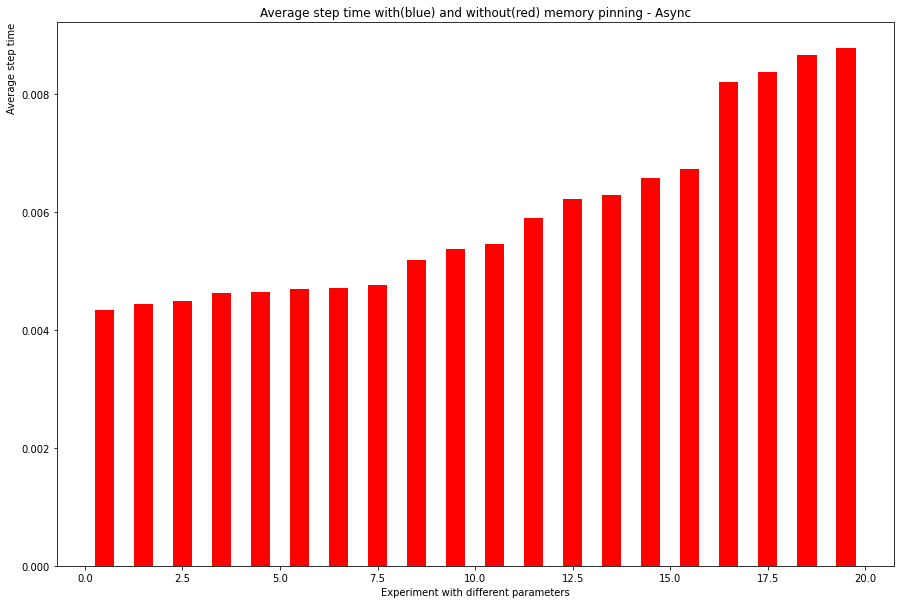

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.5 for x in range(len(data))], height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')
del data

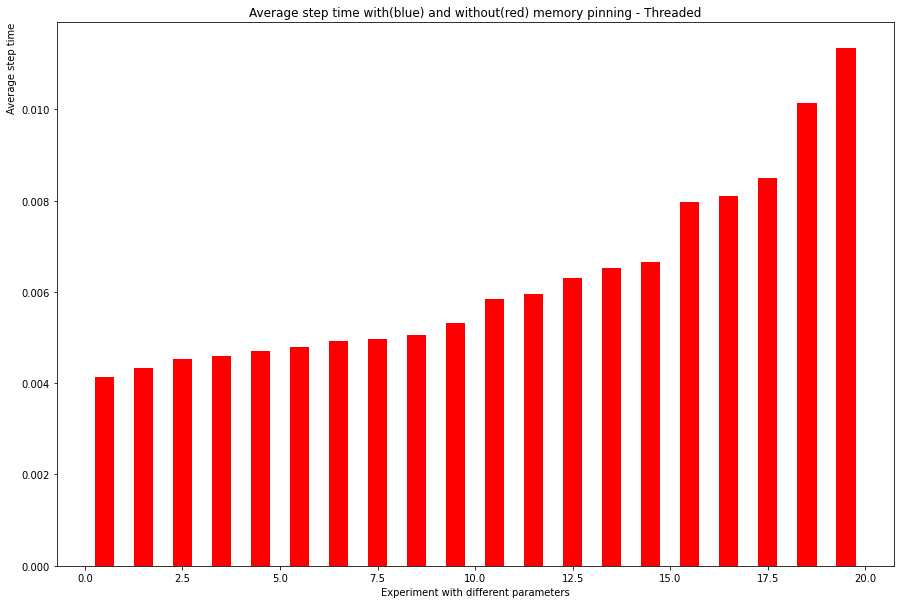

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.5 for x in range(len(data))], height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Threaded", loc='center')
del data

**S3: Threaded vs Asyncio without pinning memory** <a class="anchor" id="s3mempinboth">

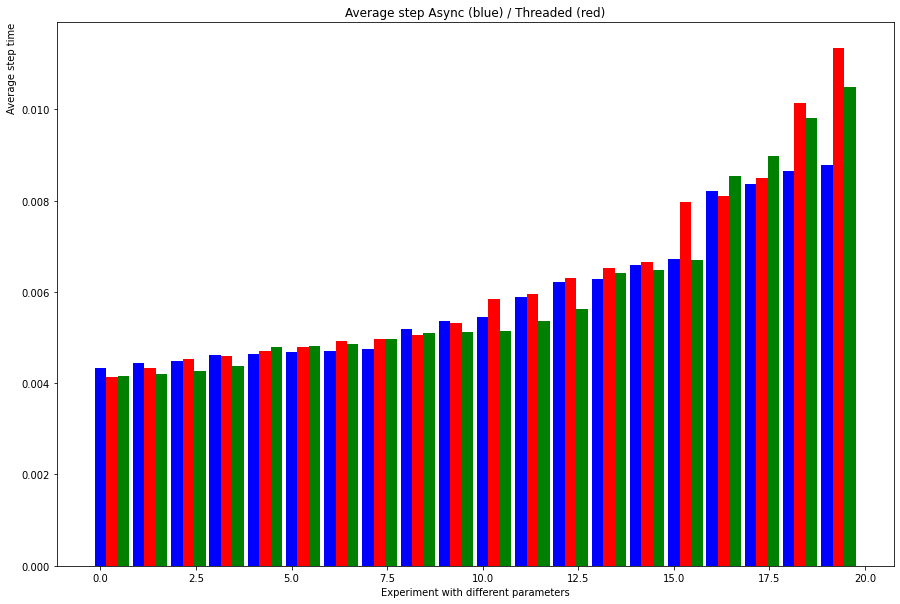

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.3, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.3 for x in range(len(data))], height=data["mean"], width=0.3, color="red")
data = data_s3_vanilla[data_s3_vanilla["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.6 for x in range(len(data))], height=data["mean"], width=0.3, color="green")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step Async (blue) / Threaded (red)", loc='center')
del data

Considering end to end implementation asyncio and threaded implementation seem to be comparable, though threaded seems to be slightly better in most cases. 

### Asyncio vs Threaded for S3 <a class="anchor" id="s3asynciovsthreaded">

In [18]:
from matplotlib.patches import Patch

num_workers_unique = np.unique(data_s3_async["num_workers"].to_numpy())
batch_size_unique = np.unique(data_s3_async["batch_size"].to_numpy())
num_fetch_workers_unique = np.unique(data_s3_async["num_fetch_workers"].to_numpy())


In [19]:
# For later comparison with Scratch
s3_pin_async = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_async = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
s3_pin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
s3_pin_vanilla = data_s3_vanilla[data_s3_vanilla["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_vanilla = data_s3_vanilla[data_s3_vanilla["pin_memory"]==0].sort_values(["mean"], ascending=True)
# Cleanup
del data_s3_async
del data_s3_threaded
del data_s3_vanilla

# Scratch storage <a class="anchor" id="scratchstorage">

In [ ]:
df_dataloader_scratch_full = extract_pandas(output_base_folder, folder_filter="e2e0810/*benchmark_e2e_scratch*")

 22%|███████████████████████████▊                                                                                                     | 1728/8024 [00:33<01:46, 59.07it/s]

In [ ]:
df_dataloader_scratch_async=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="asyncio"]
df_dataloader_scratch_threaded=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="threaded"]
df_dataloader_scratch_vanilla=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="vanilla"]
# save memory 
del df_dataloader_scratch_full
# show record num
print(f"Records {len(df_dataloader_scratch_async)}")
print(f"Records {len(df_dataloader_scratch_threaded)}")

In [ ]:
display(get_run_stats(df_dataloader_scratch_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_scratch_threaded, group_by=group_by_dataloader))

In [ ]:
print(np.unique(df_dataloader_scratch_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["batch_size"].to_numpy()))


In [ ]:
data_scratch_async = filter_data(df_dataloader_scratch_async)
data_scratch_threaded = filter_data(df_dataloader_scratch_threaded)
data_scratch_vanilla = filter_data(df_dataloader_scratch_vanilla)
# del df_dataloader_scratch_async
# del df_dataloader_scratch_threaded

In [ ]:
data_scratch_async.sort_values(["mean"], ascending=True)

In [ ]:
data_scratch_threaded.sort_values(["mean"], ascending=True)

In [ ]:
data_scratch_vanilla.sort_values(["mean"], ascending=True)

**Memory pinning** <a class="anchor" id="scratchmempin">

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.3, color="blue")
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.3 for x in range(len(data))], height=data["mean"], width=0.3, color="red")
data = data_scratch_vanilla[data_scratch_vanilla["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.6 for x in range(len(data))], height=data["mean"], width=0.3, color="green")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step Async (blue) / Threaded (red)", loc='center')
del data

### Asyncio vs Threaded vs Vanilla for Scratch <a class="anchor" id="scratchasynciovsthreaded">

In [ ]:
scratch_unpin_async = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
scratch_unpin_threaded = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
scratch_unpin_vanilla = data_scratch_vanilla[data_scratch_vanilla["pin_memory"]==0].sort_values(["mean"], ascending=True)

# async
w = 1.0/4.0
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(scratch_unpin_async)), height=scratch_unpin_async["mean"], width=w, color="blue")
ax.bar(x=[x+0.25 for x in range(len(scratch_unpin_async))], height=scratch_unpin_threaded["mean"], width=w, color="green")
ax.bar(x=[x+0.5 for x in range(len(scratch_unpin_async))], height=scratch_unpin_vanilla["mean"], width=w, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Async: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)", loc='center')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
l3 = ax.plot(range(len(scratch_unpin_async)), scratch_unpin_async["mean"], color="blue", linewidth=2, label="red - scratch, unpinned, async")
l4 = ax.plot(range(len(s3_unpin_async)), s3_unpin_async["mean"], color="blue", linewidth=3, linestyle="--", label="red - s3, unpinned, async")
l7 = ax.plot(range(len(scratch_unpin_threaded)), scratch_unpin_threaded["mean"], color="red", linewidth=2, label="black - scratch, unpinned, threaded")
l8 = ax.plot(range(len(s3_unpin_threaded)), s3_unpin_threaded["mean"], color="red", linestyle="--", linewidth=3.5, label="black - s3, unpinned, threaded")
l7 = ax.plot(range(len(scratch_unpin_vanilla)), scratch_unpin_vanilla["mean"], color="green", linewidth=2, label="black - scratch, unpinned, threaded")
l8 = ax.plot(range(len(s3_unpin_vanilla)), s3_unpin_vanilla["mean"], color="green", linestyle="--", linewidth=3.5, label="black - s3, unpinned, threaded")

# ax.fill_between(range(len(scratch_pin_async)),s3_unpin_threaded["mean"], s3_unpin_async["mean"], color="red", alpha=0.1)
# ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_async["mean"], scratch_unpin_threaded["mean"], color="gray", alpha=0.25)


# ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"S3 vs. Scratch + threaded and async + pinned and unpinned \n (S3 is dashed, Scrach is full line)", loc='center')
ax.legend()

##### Median time? 

In order to perform well, we want S3 dashed lines to be above Scratch lines. 

We find that with some combinations we can get slightly better performance.

In [ ]:
df_joined = pd.concat([s3_unpin_async[["mean", "config"]], 
                       s3_unpin_threaded[["mean"]], 
                       s3_unpin_vanilla[["mean"]], 
                       scratch_unpin_async[["mean"]], 
                       scratch_unpin_threaded[["mean"]], 
                       scratch_unpin_vanilla[["mean"]]], axis=1)
df_joined.reset_index(drop=True, inplace=True)

df_joined['diff_as'] = df_joined.apply(lambda row: float(row[4] - row[0]) , axis = 1)
df_joined['diff_thr'] = df_joined.apply(lambda row: float(row[6] - row[2]) , axis = 1)
# df_joined['diff_thr'] = df_joined.apply(lambda row: float(row[6] - row[2]) , axis = 1)
df_joined = df_joined.set_axis(["s3_as_m", 
                                "s3_as_m_cfg", 
                                "s3_thr_m", 
                                "s3_vnl_m", 
                                "sc_as_m", 
                                "sc_thr_m", 
                                "sc_vnl_m", 
                                "diff_as",
                                "diff_thr"], axis=1, inplace=False)
df_joined = df_joined.sort_values(["sc_as_m"], ascending=True)
df_joined

**When is S3 better?**
Config order: `{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}`

In [ ]:
np.unique(df_dataloader_scratch_threaded["batch_size"].to_numpy())

In [ ]:
np.unique(df_dataloader_scratch_threaded["num_workers"].to_numpy())

In [ ]:
def plot_stats(d1, d2, d3, measure, title):   
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.axis(ymin=0.003, ymax=0.012)
    for i, (batch_size, color) in enumerate(zip([64, 128, 256, 512], ["red", "gray", "lime", "aqua"])):
        s3_fix_thr = d1[(d1["num_fetch_workers"]==16) & (d1["batch_size"]==batch_size)]
        s3_fix_as = d2[(d2["num_fetch_workers"]==16) & (d2["batch_size"]==batch_size)]
        s3_fix_vnl = d3[(d3["num_fetch_workers"]==16) & (d3["batch_size"]==batch_size)]
        
        s3_fix_thr = s3_fix_thr.sort_values(["num_workers"], ascending=True)
        s3_fix_as = s3_fix_as.sort_values(["num_workers"], ascending=True)
        s3_fix_vnl = s3_fix_vnl.sort_values(["num_workers"], ascending=True)

        if i == 0:
            xrange = s3_fix_thr["num_workers"] - 2
        else:
            xrange = s3_fix_thr["num_workers"] + i - 2
        ax.bar(x=xrange, height=s3_fix_thr[measure], width=0.25, color=color, label=f"Async, {batch_size}")
        ax.bar(x=xrange+0.3, height=s3_fix_as[measure], hatch="xxx", color=color, width=0.25, label=f"Threads, {batch_size}")
        ax.bar(x=xrange+0.6, height=s3_fix_vnl[measure], hatch="...", color=color, width=0.25, label=f"Vanilla, {batch_size}")

    ax.grid(linestyle='--', which="both")
    ax.set_xticks(s3_fix_thr["num_workers"])

    ax.set_xlabel(f"Number of workers", loc="center")
    ax.set_ylabel("Mean step time", loc="top")
    ax.set_title(f"{title}: Asyncio vs. Threaded vs. Vanilla Pytorch + Batch sizes", loc='center')
    ax.legend()

In [ ]:
plot_stats(s3_unpin_async, s3_unpin_threaded, s3_unpin_vanilla, "mean", "S3")

In [ ]:
plot_stats(s3_unpin_async, s3_unpin_threaded, s3_unpin_vanilla, "median", "S3")

In [ ]:
plot_stats(scratch_unpin_async, scratch_unpin_threaded, scratch_unpin_vanilla, "mean", "Scratch")

In [ ]:
plot_stats(scratch_unpin_async, scratch_unpin_threaded, scratch_unpin_vanilla, "median", "Scratch")

In [ ]:
d1=scratch_unpin_async
d2=scratch_unpin_threaded 
d3=scratch_unpin_vanilla

d4=s3_unpin_async
d5=s3_unpin_threaded
d6=s3_unpin_vanilla

measure = "median"
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.003, ymax=0.012)
for i, (batch_size, color) in enumerate(zip([64, 128, 256, 512], ["red", "gray", "lime", "aqua"])):
    sc_fix_thr = d1[(d1["num_fetch_workers"]==16) & (d1["batch_size"]==batch_size)]
    sc_fix_as =  d2[(d2["num_fetch_workers"]==16) & (d2["batch_size"]==batch_size)]
    sc_fix_vnl = d3[(d3["num_fetch_workers"]==16) & (d3["batch_size"]==batch_size)]
    s3_fix_thr = d4[(d4["num_fetch_workers"]==16) & (d4["batch_size"]==batch_size)]
    s3_fix_as =  d5[(d5["num_fetch_workers"]==16) & (d5["batch_size"]==batch_size)]
    s3_fix_vnl = d6[(d6["num_fetch_workers"]==16) & (d6["batch_size"]==batch_size)]

    sc_fix_thr = sc_fix_thr.sort_values(["num_workers"], ascending=True)
    sc_fix_as = sc_fix_as.sort_values(["num_workers"], ascending=True)
    sc_fix_vnl = sc_fix_vnl.sort_values(["num_workers"], ascending=True)
    s3_fix_thr = s3_fix_thr.sort_values(["num_workers"], ascending=True)
    s3_fix_as = s3_fix_as.sort_values(["num_workers"], ascending=True)
    s3_fix_vnl = s3_fix_vnl.sort_values(["num_workers"], ascending=True)

    if i == 0:
        xrange = s3_fix_thr["num_workers"] - 2
    else:
        xrange = s3_fix_thr["num_workers"] + i - 2
    ax.bar(x=xrange, height=s3_fix_thr[measure], width=0.13, color=color, label=f"s3 Async, {batch_size}")
    ax.bar(x=xrange+0.15, height=s3_fix_as[measure], hatch="xxx", color=color, width=0.13, label=f"s3 Threads, {batch_size}")
    ax.bar(x=xrange+0.3, height=s3_fix_vnl[measure], hatch="...", color=color, width=0.13, label=f"s3 Vanilla, {batch_size}")

    ax.bar(x=xrange+0.45, height=sc_fix_thr[measure], hatch="+++", width=0.13, color=color, label=f"sc Async, {batch_size}")
    ax.bar(x=xrange+0.6, height=sc_fix_as[measure],  hatch="///", color=color, width=0.13, label=f"sc Threads, {batch_size}")
    ax.bar(x=xrange+0.75, height=sc_fix_vnl[measure], hatch="---", color=color, width=0.13, label=f"sc Vanilla, {batch_size}")

    
ax.grid(linestyle='--', which="both")
ax.set_xticks(s3_fix_thr["num_workers"])

ax.set_xlabel(f"Number of workers", loc="center")
ax.set_ylabel("Mean step time", loc="top")
ax.set_title(f"Asyncio vs. Threaded vs. Vanilla Pytorch + Batch sizes", loc='center')
ax.legend()

Example where Scratch is better